<a href="https://colab.research.google.com/github/AnnSenina/python_hse_2024/blob/main/notebooks/13_logisticreg%2C%20validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Логистическая регрессия

В отличие от линейной, поможет нам предсказать категориальную переменную (как правило, бинарную)

Считается простым алгоритмом, но точность относительно невысокая

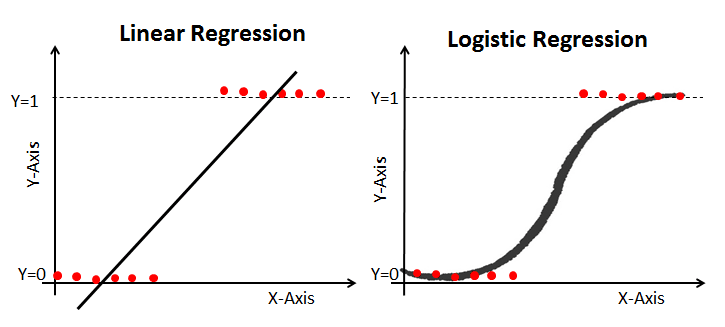

In [1]:
# все импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import load_dataset
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
# Давайте возьмем один из самый известных датасетов - пассажиры Титаника
df = load_dataset("titanic")
df

### Документация

Все очень похоже на линейную регрессию: [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

+ Метрики: [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)

In [27]:
x = df[['pclass']] # будем смотреть, как класс пассажира влияет на исход катастрофы
y = df["survived"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [28]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

In [ ]:
df_logreg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_logreg

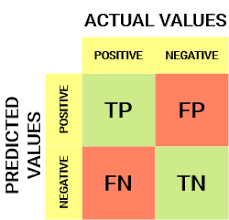

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
print(classification_report(y_test, y_pred))

# precision (точность) и recall (полнота)

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм (аналогично для отрицательного).

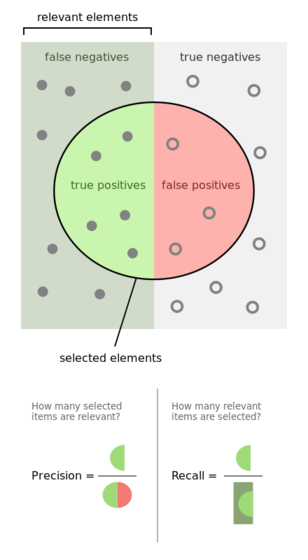

In [ ]:
df['survived'].value_counts() # классы не сбалансированы

In [ ]:
log_reg = LogisticRegression(class_weight="balanced") # введем гиперпараметр - баланс классов
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print(classification_report(y_test, y_pred))

In [ ]:
accuracy_score(y_pred, y_test) # точность модели
# приятная метрика: процент правильно предсказанных значений

In [ ]:
y_pred_proba = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label=" AUC= "+str(auc))
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(loc=4);

### Практика:
- перекодируйте пол человека
- добавьте его в модель логистической регрессии как еще один х
- напечатайте classification_report

Возможное решение

In [29]:
# @title
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)

In [39]:
# @title
x = df[['pclass', 'sex']] # будем смотреть, как класс пассажира влияет на исход катастрофы
y = df["survived"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

In [ ]:
# @title
print(classification_report(y_test, y_pred))

### Кросс-валидация

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
# все возможные метрики
sklearn.metrics.get_scorer_names()

In [24]:
scoring = {
           'roc_auc' : 'roc_auc',
           'accuracy' : 'accuracy',
           'precision' : 'precision',
           'recall' : 'recall'
           }
# выбираем те метрики, которые нам нужны, причем мы можем дать им свои обозначения

In [ ]:
scores = cross_validate(log_reg,
                        x_train,
                        y_train,
                        scoring=scoring,
                        cv=5, # делим наши данные на 5 выборок
                        return_estimator=True,
                        return_train_score=True)

scores

In [ ]:
scores_df = pd.DataFrame.from_dict(scores)
scores_df

Чтобы вытащить одну из пяти моделей, нужно обратиться к ней по индексу:

In [43]:
y_pred_cv_4 = scores['estimator'][0].predict(x_test)

Теперь мы можем или пользоваться лучшим эстиматором или обучиться снова на всех данных (вернуться к подходу 1).

А можно также подбирать гиперпараментры с помощью кросс-валидации!

In [ ]:
parameters = {'penalty' : ['l1', 'l2', 'elasticnet', None],
              'class_weight' : ['balanced', None],
              'solver' : ['lbfgs', 'liblinear', 'saga']}
grid = GridSearchCV(LogisticRegression(), parameters)
grid.fit(x, y)
tree_model = grid.best_estimator_
print(grid.best_score_, grid.best_params_)

### Еще примеры:
* [Спам-письма](https://github.com/svetlana21/Spam-classifier)
* [Мошенничество](https://vc.ru/u/1389654-machine-learning/651087-poshagovoe-rukovodstvo-po-obnaruzheniyu-moshennichestva-s-ispolzovaniem-logisticheskoy-regressii-python-kompleksnyy-podhod?__cf_chl_tk=7oOPtgov4EKf4x4jPZF9q_Zs63JVd4ywkbxs9kCRruA-1683867846-0-gaNycGzNDOU)
* [Кредиты в банке](https://medium.com/nuances-of-programming/%D0%BF%D0%BE%D1%88%D0%B0%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5-%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8-%D0%B2-python-a7c650ae77c2)